In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from nltk.corpus import stopwords
from textblob import TextBlob

In [5]:
df=pd.read_csv('yelp.csv')

In [56]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


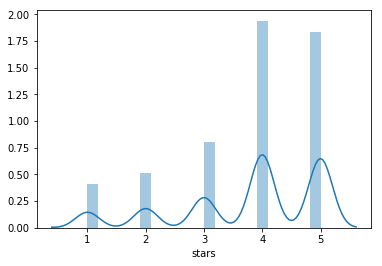

In [21]:
sns.distplot(df.stars)

basic preprocessing 

In [ ]:
#convert to lowercase 
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'] = df['text'].str.replace('[^\w\s]','') # Remove punctuation
#Remove stop words
stop = stopwords.words('english')
stop.extend(['you','re','spa'])
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#spelling correction
df['text'].apply(lambda x: str(TextBlob(x).correct()))

In [68]:
#common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq

good      6713
place     6634
food      6079
great     5066
like      4970
one       4024
get       3801
time      3452
go        3446
really    3348
dtype: int64

In [69]:
#rare words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

gaves                1
awesomeeverything    1
seelike              1
memberlol            1
distancea            1
saladmacaroni        1
acacia               1
8510                 1
ambiencefour         1
rosemead             1
dtype: int64

Advanced text processing 

In [9]:
#term frequency 
tf1 = (df['text'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1.head()

,words,tf
0,pizza,4
1,calzone,4
2,got,3
3,like,3
4,seated,3


In [27]:
#inverse document frequency- for only reviews with 1 or 5 stars due to magnitude of data 
df_sub=df[(df['stars']== 1) | (df['stars']==5)]
for i,word in enumerate(df_sub['text']):
    tf1.loc[i, 'idf'] = np.log(df_sub.shape[0]/(len(df_sub[df_sub['text'].str.contains(word)])))

tf1.head()

,words,tf,idf
0,pizza,4.0,8.315322
1,calzone,4.0,8.315322
2,got,3.0,8.315322
3,like,3.0,8.315322
4,seated,3.0,8.315322


In [28]:
#Term Frequency – Inverse Document Frequency (TF-IDF)
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.head()

,words,tf,idf,tfidf
0,pizza,4.0,8.315322,33.261287
1,calzone,4.0,8.315322,33.261287
2,got,3.0,8.315322,24.945965
3,like,3.0,8.315322,24.945965
4,seated,3.0,8.315322,24.945965


sentiment analysis 

In [33]:
df['text'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (0.43888888888888883, 0.6641203703703705)
1                   (0.17, 0.6166666666666667)
2                    (0.6, 0.6000000000000001)
3                    (0.5666666666666667, 0.8)
4     (0.36111111111111116, 0.788888888888889)
Name: text, dtype: object

In [34]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['text','sentiment']].head()

,text,sentiment
0,wife took birthday breakfast excellent weather...,0.438889
1,idea people give bad reviews place goes show p...,0.170000
2,love gyro plate rice good also dig candy selec...,0.600000
3,rosie dakota love chaparral dog park convenien...,0.566667
4,general manager scott petello good egg go deta...,0.361111


word 2 vec 

In [38]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [39]:
from gensim.models import KeyedVectors # load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [41]:
model['wife']

array([ 0.33954  , -0.41367  ,  0.22616  , -0.040106 ,  0.10489  ,
        0.72435  ,  0.092193 ,  0.44002  ,  0.32346  ,  0.1369   ,
       -0.14326  ,  0.62633  ,  0.17516  ,  0.74118  ,  0.20934  ,
       -0.71018  ,  0.20261  , -0.33897  , -0.74968  ,  1.0765   ,
       -0.40806  ,  0.094819 ,  0.3135   ,  0.86049  ,  0.43735  ,
        0.25478  , -0.64706  , -1.3142   ,  0.39623  ,  0.35877  ,
        0.30925  ,  1.0754   ,  1.225    ,  0.12411  , -0.49617  ,
        0.37415  ,  0.54215  ,  0.14841  ,  0.66266  ,  0.29481  ,
       -0.57182  , -0.039851 ,  0.92182  , -0.52839  ,  0.094058 ,
       -0.11741  , -0.79228  , -0.31416  ,  0.68354  , -0.40774  ,
       -0.05028  , -0.22371  ,  1.2423   ,  1.2613   ,  0.29719  ,
       -1.9155   , -0.7874   , -0.082381 ,  0.0086433,  0.31623  ,
        0.17978  ,  1.0176   ,  0.12718  , -0.12217  ,  0.34378  ,
       -0.24003  ,  1.0147   ,  0.68566  ,  0.19761  ,  0.35222  ,
       -0.31113  ,  0.05139  , -0.12831  , -0.23403  ,  0.3651

In [42]:
model['took']

array([ 3.7204e-01, -3.4461e-01, -2.9330e-01, -7.4828e-02,  6.3550e-03,
        7.3233e-02,  1.8162e-01,  4.8748e-01, -5.9588e-01, -7.8790e-02,
        4.1813e-01,  2.7830e-01, -6.4686e-02,  3.9414e-01,  1.2458e-01,
       -1.9754e-01,  8.1626e-02,  2.4704e-01, -4.7981e-01, -1.5825e-01,
        1.1863e+00, -1.1287e-01,  4.0052e-01,  2.1474e-01, -1.4538e-01,
       -5.0650e-01, -4.6493e-01, -9.6516e-02,  3.2725e-01, -4.8246e-01,
       -1.4512e-01,  5.6280e-01, -2.1192e-03,  1.3677e-01, -5.0256e-01,
       -3.1250e-01, -3.4967e-01,  7.8849e-01, -3.6061e-01,  2.0193e-01,
       -7.5335e-01, -3.2116e-01,  6.8214e-01, -4.4715e-01,  3.5000e-02,
       -5.4333e-02,  8.0687e-02, -2.4576e-01,  8.1051e-01, -5.8676e-01,
       -2.1839e-01,  2.3273e-02, -1.1143e-01,  1.3770e+00, -2.5087e-01,
       -2.7768e+00, -6.1519e-01, -2.4199e-02,  1.1349e+00,  5.6768e-01,
       -9.5720e-03,  7.6185e-01, -1.3215e-02,  2.8555e-01,  4.2710e-01,
       -2.5556e-01,  4.4353e-02,  4.7710e-02, -1.4676e-01,  5.02

In [43]:
(model['wife']+model['took'])/2

array([ 0.35579002, -0.37914002, -0.03357   , -0.057467  ,  0.0556225 ,
        0.3987915 ,  0.1369065 ,  0.46375   , -0.13620998,  0.029055  ,
        0.137435  ,  0.452315  ,  0.055237  ,  0.56766   ,  0.16696   ,
       -0.45385998,  0.142118  , -0.045965  , -0.614745  ,  0.45912504,
        0.38912   , -0.0090255 ,  0.35701   ,  0.537615  ,  0.145985  ,
       -0.12586   , -0.555995  , -0.705358  ,  0.36174   , -0.06184499,
        0.082065  ,  0.8191    ,  0.6114404 ,  0.13044   , -0.49936503,
        0.030825  ,  0.09624001,  0.46845   ,  0.151025  ,  0.24836999,
       -0.662585  , -0.1805055 ,  0.80198   , -0.48777   ,  0.064529  ,
       -0.0858715 , -0.35579652, -0.27995998,  0.747025  , -0.49725   ,
       -0.134335  , -0.1002185 ,  0.565435  ,  1.31915   ,  0.02316001,
       -2.34615   , -0.701295  , -0.05329   ,  0.5717716 ,  0.441955  ,
        0.085104  ,  0.889725  ,  0.0569825 ,  0.08169   ,  0.38544   ,
       -0.24779502,  0.52952653,  0.366685  ,  0.025425  ,  0.42

## Top positive and negative reviews

In [ ]:
import scattertext as st
import spacy
from pprint import pprint

In [4]:
 convention_df = st.SampleCorpora.ConventionData2012.get_data()  

In [5]:
convention_df.head()

,party,speaker,text
0,democrat,BARACK OBAMA,Thank you. Thank you. Thank you. Thank you so ...
1,democrat,MICHELLE OBAMA,"Thank you so much. Tonight, I am so thrilled a..."
2,democrat,RICHARD DURBIN,Thank you. It is a singular honor to be here t...
3,democrat,JOSEPH BIDEN,"Hey, Delaware. \nAnd my favorite Democrat, Jil..."
4,democrat,JILL BIDEN,"Hello. \nThank you, Angie. I'm so proud of how..."


In [59]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,wife took birthday breakfast excellent weather...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,idea people give bad reviews place goes show p...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love gyro plate rice good also dig candy selec...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,rosie dakota love chaparral dog park convenien...,review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,general manager scott petello good egg go deta...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [73]:
nlp = spacy.load('en')

In [74]:
df_sub=df[(df['stars']== 1) | (df['stars']==5)]
df_sub = df_sub.sample(frac=0.04)

In [75]:
df_sub.loc[df_sub['stars'] == 1, ['stars']] = 'one'

In [76]:
df_sub.loc[df_sub['stars'] == 5, ['stars']] = 'five'

In [82]:
stop = stopwords.words('english')
stop.extend(['you','re','spa'])
df_sub['text'] = df_sub['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [83]:
corpus = st.CorpusFromPandas(df_sub, 
                              category_col='stars', 
                              text_col='text',
                              nlp=nlp).build()

In [84]:
 html = st.produce_scattertext_explorer(corpus,
          category='one',
          category_name='low rating',
          not_category_name='high rating',
          width_in_pixels=1000,
          metadata=df_sub['type'])
open("Convention-Visualization2.html", 'wb').write(html.encode('utf-8'))

420800